# Nutrition Data Practice
Data source: https://www.kaggle.com/datasets/tharunmss/nutritional-breakdown-of-foods

In [83]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import tensorflow as tfun
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
import umap

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from importlib import reload
import cluster_utils
reload(cluster_utils)

from cluster_utils import *


### Part 1: Load Dataset and Investigate Feature Distributions

**Thoughts**: 

1. **Transformation and Scaling**:
    
    There are eleven features (including Caloria Value) in the dataset. Almost all of them show highly right skewed distributions, which could impact the model performance, especially distance based clustering models. To ensure the model performance, scaling and Yeo-Johnson transformation (in terms of 0 values in the dataset) are applied to try to make the distributions close to normal distribution. 

    - After scaling, the distribution doesn't change a lot.

    - The Yeo-Johnson transformation helps normalise the distributions.

    - Based ont the Yeo-Johnson transformation, scaling further standardise the normalised distributions.

    To assess how sensitive the clustering model is to data distribution, four versions of the dataset were used in subsequent modelling: the original (df_ori), scaled (df_scaled), transformed (df_trans), and transformed plus scaled (df_trans_scaled).

2. **Correlation and Principal Component Analysis (PCA)**:

    Correlation analysis provided a basic overview of the relationships between variables. However, its interpretive value is limited due to the potential non-linearity in the data. 
    
    PCA was applied to explore dimensionality reduction. The first five principal components accounted for approximately 90% of the total variance, suggesting that much of the information in the original dataset can be retained with fewer dimensions. However, interpreting the principal components proved challenging, as the loadings did not reveal clear groupings of variables. This limited the ability to assign meaningful labels (e.g., “vitamin-related” or “micronutrient-related”) to individual components. Moreover, as PCA is a linear technique, it may not fully capture complex or non-linear relationships among features.



In [84]:
# Load dataset
df_raw = pd.read_csv('cleaned_nutrition_dataset.csv')

In [85]:
# View dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Vitamin C        3454 non-null   float64
 1   Vitamin B11      3454 non-null   float64
 2   Sodium           3454 non-null   float64
 3   Calcium          3454 non-null   float64
 4   Carbohydrates    3454 non-null   float64
 5   food             3454 non-null   object 
 6   Iron             3454 non-null   float64
 7   Caloric Value    3454 non-null   float64
 8   Sugars           3454 non-null   float64
 9   Dietary Fiber    3454 non-null   float64
 10  Fat              3454 non-null   float64
 11  Protein          3454 non-null   float64
 12  food_normalized  3454 non-null   object 
dtypes: float64(11), object(2)
memory usage: 350.9+ KB


In [86]:
# Preparation: Save food names, remove the food and food_normalized columns in dataset for modelling, get features
df_text = df_raw[['food_normalized']]

df_ori = df_raw.drop(['food', 'food_normalized'], axis=1)
features = df_ori.select_dtypes(include='number').columns
df_ori.head()

,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
0,0.082,0.086,0.018,2.8,0.073,0.027,88.0,0.0,0.0,9.8,0.058
1,0.400,0.005,0.065,10.2,3.700,0.700,99.0,1.7,0.9,8.8,2.800
2,0.000,0.000,0.000,0.0,0.000,0.000,120.0,0.0,0.0,13.6,0.000
3,0.000,0.000,0.000,0.0,0.000,0.000,1966.0,0.0,0.0,218.0,0.000
4,0.000,0.000,0.000,0.0,0.000,0.000,123.0,0.0,0.0,13.6,0.000


In [87]:
# View the distribution of the remaining columns
df_ori.describe()

,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
count,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000
mean,9.501021,11.447140,141.437806,53.953960,18.724570,1.627954,227.591546,5.693513,2.157695,12.006807,10.819314
std,70.387542,33.849817,973.168394,103.339195,26.232674,4.384574,336.277025,13.136356,4.748876,26.726515,27.250089
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029000,0.057000,4.647500,1.700000,0.200000,60.050000,0.000000,0.000000,0.500000,1.262500
50%,0.300000,0.075000,0.200000,21.940000,9.110000,0.700000,134.415000,0.920000,0.710000,4.105000,3.800000
75%,5.382500,4.327500,21.372500,60.600000,26.400000,1.600000,285.007500,5.207500,2.327500,12.500000,9.242500
max,3872.000000,550.520000,14174.590000,1283.500000,390.200000,121.200000,6077.000000,291.500000,76.500000,550.700000,560.300000


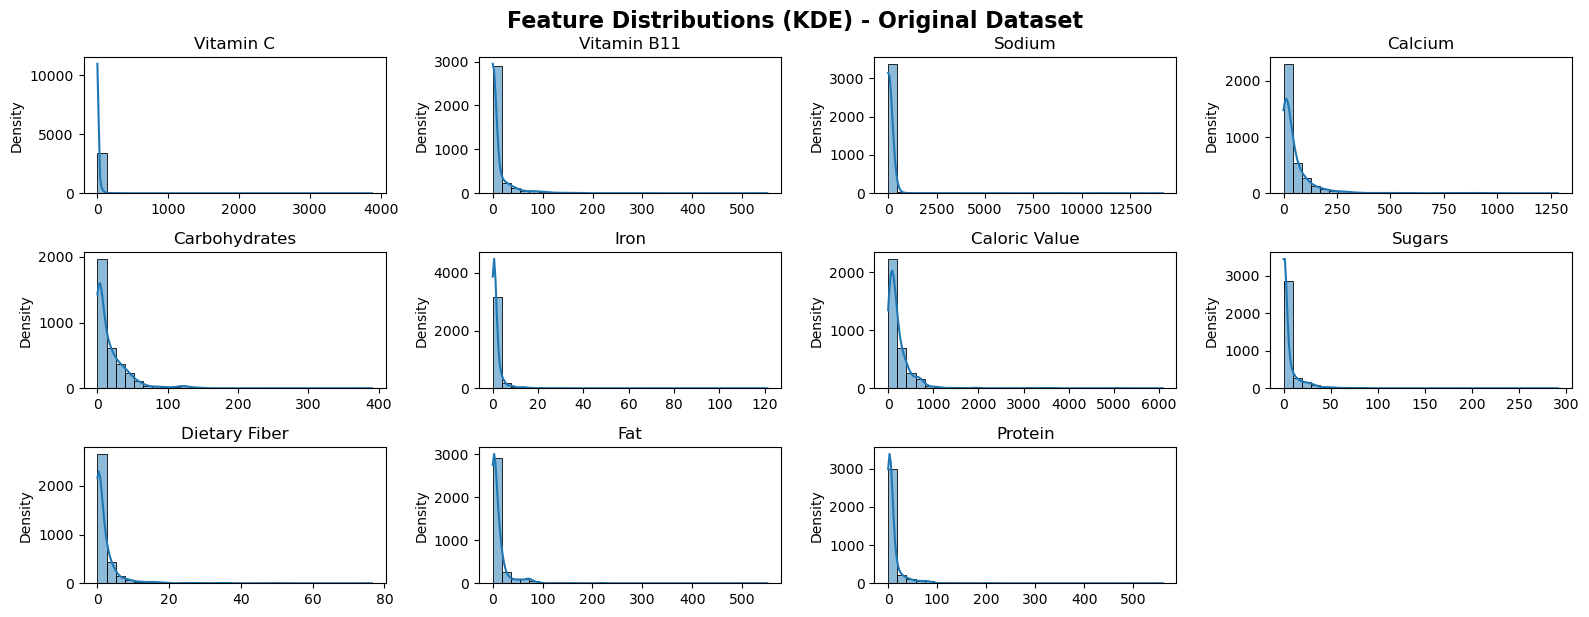

In [88]:
# Visualize the distribution
plt.figure(figsize=(16, 6))
for i, col in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.histplot(data=df_ori[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("Density")

plt.tight_layout()
plt.suptitle("Feature Distributions (KDE) - Original Dataset", fontsize=16, fontweight='bold', y=1.02)
plt.show()

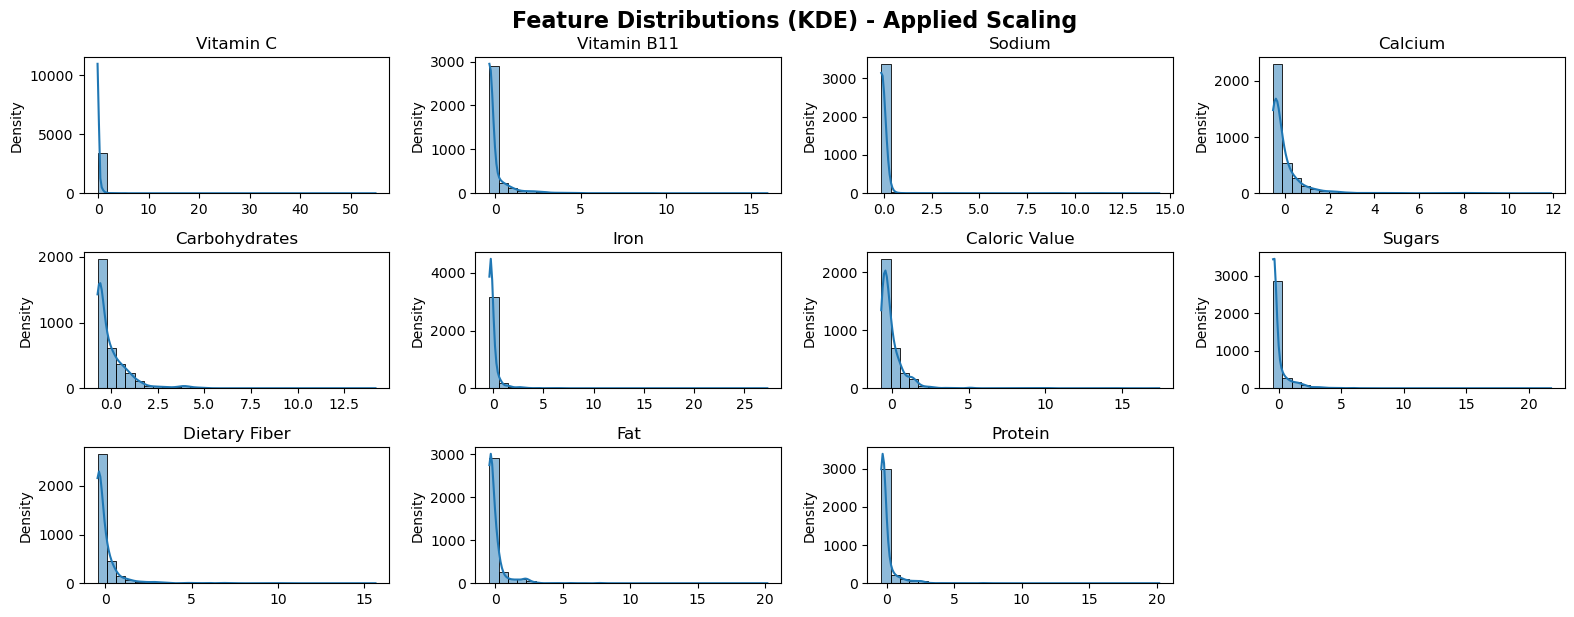

In [89]:
# Try scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_ori)
df_scaled = pd.DataFrame(X_scaled, columns=df_ori.columns)

# Visualize the distribution
plt.figure(figsize=(16, 6))
for i, col in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.histplot(data=df_scaled[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("Density")

plt.tight_layout()
plt.suptitle("Feature Distributions (KDE) - Applied Scaling", fontsize=16, fontweight='bold', y=1.02)
plt.show()

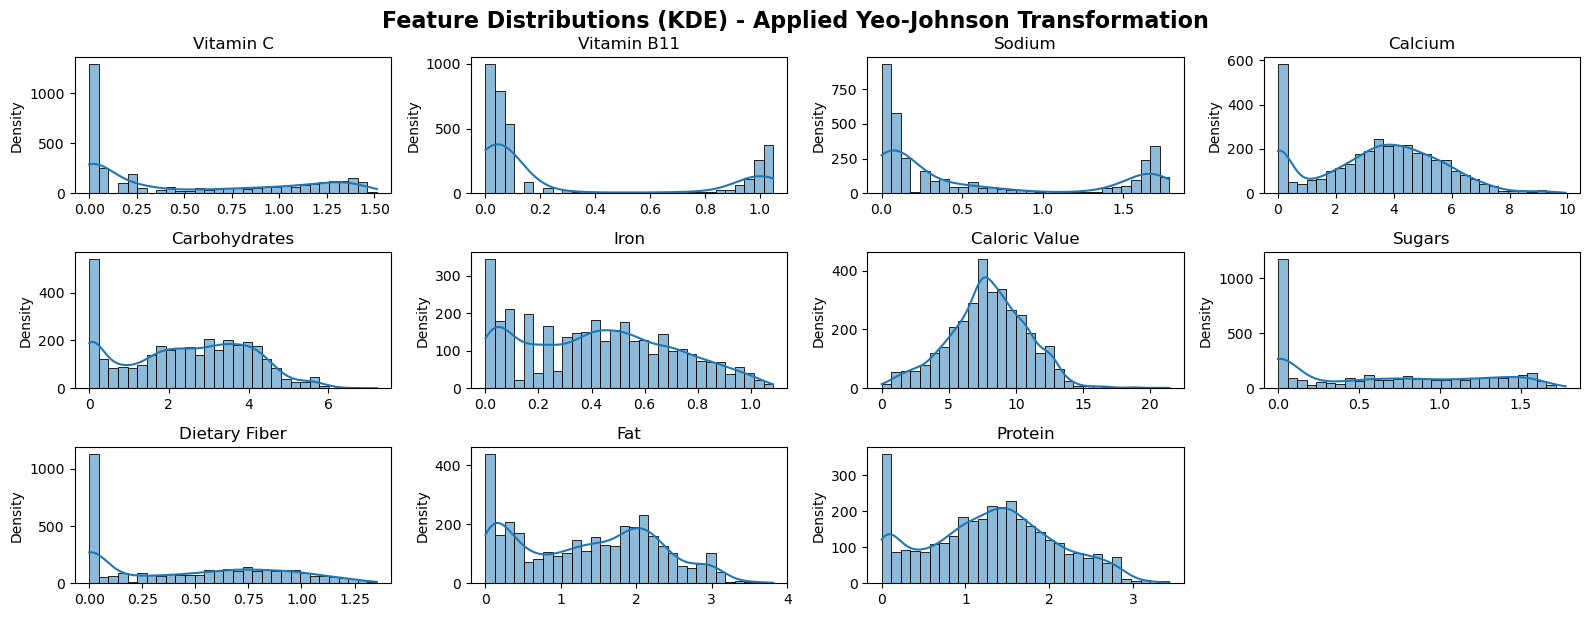

In [90]:
# Try transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)  # standardize=False keeps original scale
X_trans = pt.fit_transform(df_ori)
df_trans = pd.DataFrame(X_trans, columns=df_ori.columns)

# Visualize the distribution
plt.figure(figsize=(16, 6))
for i, col in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.histplot(data=df_trans[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("Density")

plt.tight_layout()
plt.suptitle("Feature Distributions (KDE) - Applied Yeo-Johnson Transformation", fontsize=16, fontweight='bold', y=1.02)
plt.show()

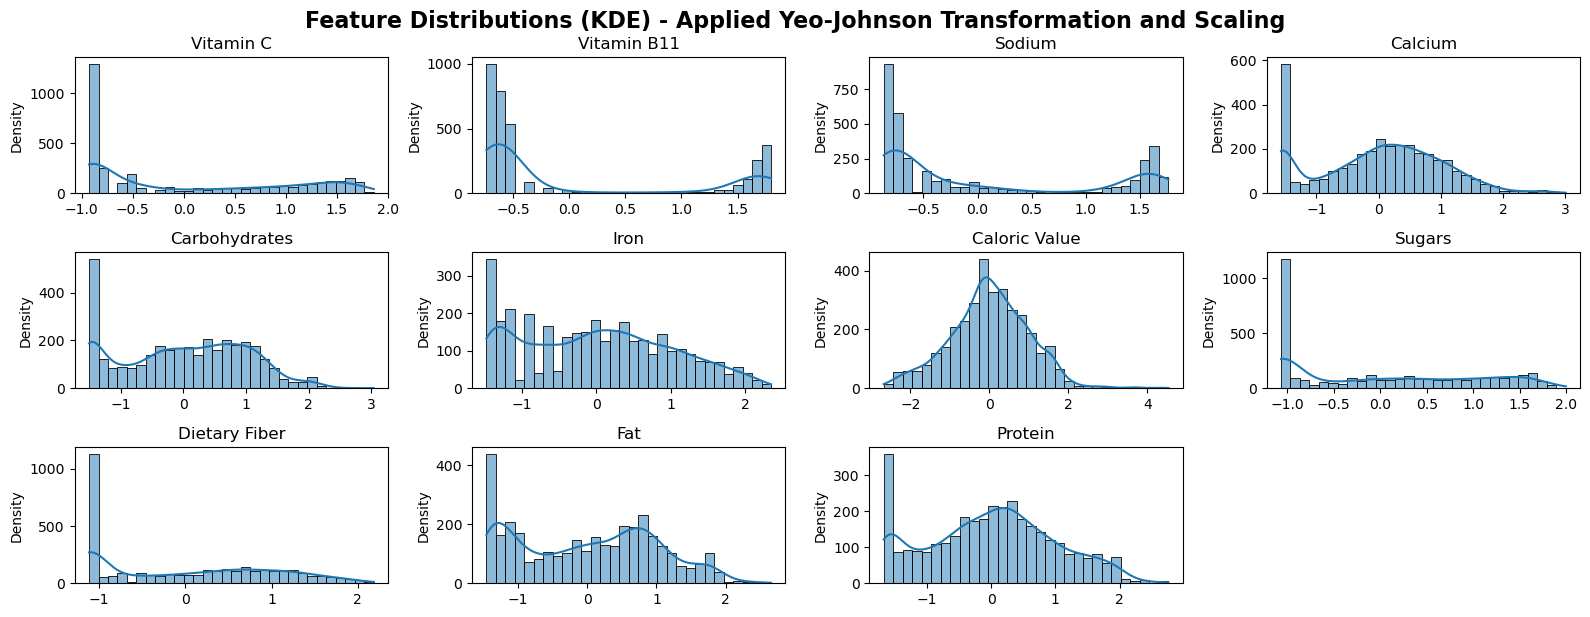

In [91]:
# Try transformation and scaling
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_trans_scaled = pt.fit_transform(df_ori)
df_trans_scaled = pd.DataFrame(X_trans_scaled, columns=df_ori.columns)

# Visualize the distribution
plt.figure(figsize=(16, 6))
for i, col in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.histplot(data=df_trans_scaled[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("Density")

plt.tight_layout()
plt.suptitle("Feature Distributions (KDE) - Applied Yeo-Johnson Transformation and Scaling", fontsize=16, fontweight='bold', y=1.02)
plt.show()

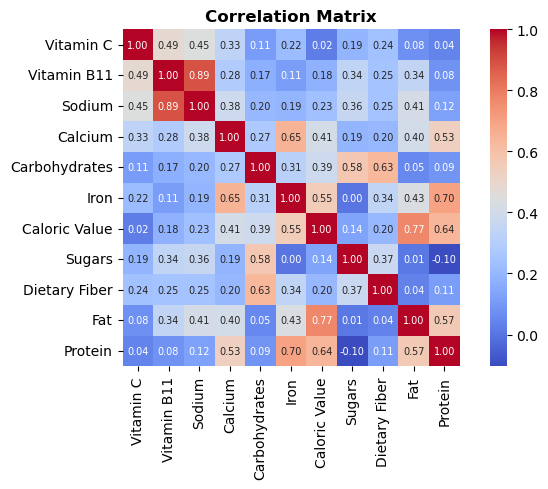

In [92]:
# Plot correlation matrix
plt.figure(figsize=(7, 5))
sns.heatmap(df_trans_scaled.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True, annot_kws={"size": 7})
plt.title("Correlation Matrix", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

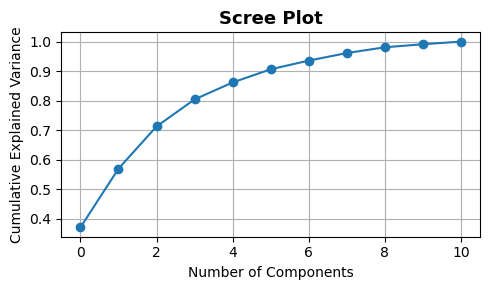

In [93]:
# Review PCA
pca = PCA()
pca.fit(df_trans_scaled)

# Plot scree plot to understand the variance explained by each PC
plt.figure(figsize=(5, 3))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot', fontsize=13, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

In [94]:
# Understand the feature loadings to each PC
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=df_trans_scaled.columns)
display(loadings.round(3).style.format("{:.3f}").set_caption("PCA Loadings (Feature Contributions)"))

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Vitamin C,0.213,-0.281,-0.260,0.530,0.061,0.711,0.063,-0.036,-0.064,-0.073,0.056
Vitamin B11,0.295,-0.349,-0.403,-0.134,0.157,-0.237,0.056,-0.232,-0.071,0.193,-0.657
Sodium,0.326,-0.310,-0.380,-0.145,0.056,-0.312,-0.089,-0.124,0.069,-0.082,0.705
Calcium,0.362,0.104,-0.027,0.355,-0.530,-0.250,-0.380,0.362,-0.291,0.150,-0.070
Carbohydrates,0.258,-0.229,0.543,-0.112,-0.019,0.073,-0.388,-0.453,-0.220,-0.399,-0.070
Iron,0.358,0.273,0.145,0.361,0.037,-0.159,0.013,-0.234,0.747,-0.006,-0.079
Caloric Value,0.360,0.284,0.107,-0.374,0.075,0.372,-0.127,-0.128,-0.059,0.662,0.141
Sugars,0.190,-0.412,0.264,-0.269,-0.553,0.116,0.495,0.177,0.236,0.030,-0.013
Dietary Fiber,0.244,-0.249,0.420,0.152,0.603,-0.168,0.128,0.497,-0.088,0.123,0.039
Fat,0.334,0.274,-0.229,-0.408,0.106,0.225,-0.131,0.441,0.142,-0.524,-0.164


### Part 2: Try Different Clustering Methods with the Datasets

#### 2.1 Distance-based Method: K-means

**Thoughts**: 

1. **Feature Scaling is Crucial**  
   As a distance-based algorithm, K-means is highly sensitive to the scale of features. Failing to standardise the dataset can cause features with larger numerical ranges to dominate the distance calculation, leading to misleading cluster assignments and artificially inflated model performance.

2. **Transformed Dataset Might Underperform Due to Shape Assumptions**  
   In this project, applying K-means to the scaled and transformed dataset resulted in noticeably poorer clustering performance, as indicated by the metrics (Silhouette Score: 0.279; Calinski-Harabasz Score: 1162.150; Davies-Bouldin Score: 1.410). 
   
   This suggests that K-means' inherent assumption of **spherical, equally sized clusters** may not align well with data that has been non-linearly transformed or standardised in a way that distorts its natural structure.

3. **Role and Limitation of PCA**  
   Principal Component Analysis (PCA) can assist in understanding the structure and separability of data by projecting it into lower dimensions. While useful for visualising clusters, especially in 2D (e.g., PC1 vs PC2), PCA often fails to fully capture the complexity of high-dimensional clustering results. This can make visual interpretation incomplete or ambiguous, especially when cluster boundaries are non-linear or overlapping. In these cases, radar charts could be a better alternative.

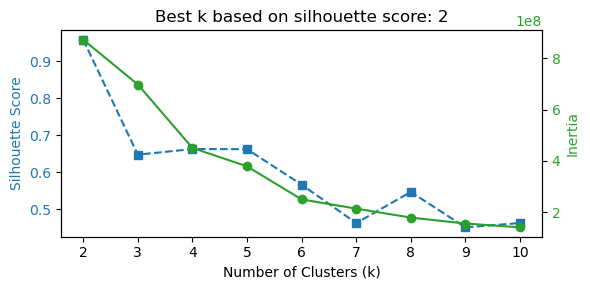

Cluster Evaluation Metrics:
 - Silhouette Score:       0.958
 - Calinski-Harabasz Score: 11278.900
 - Davies-Bouldin Score:    0.271



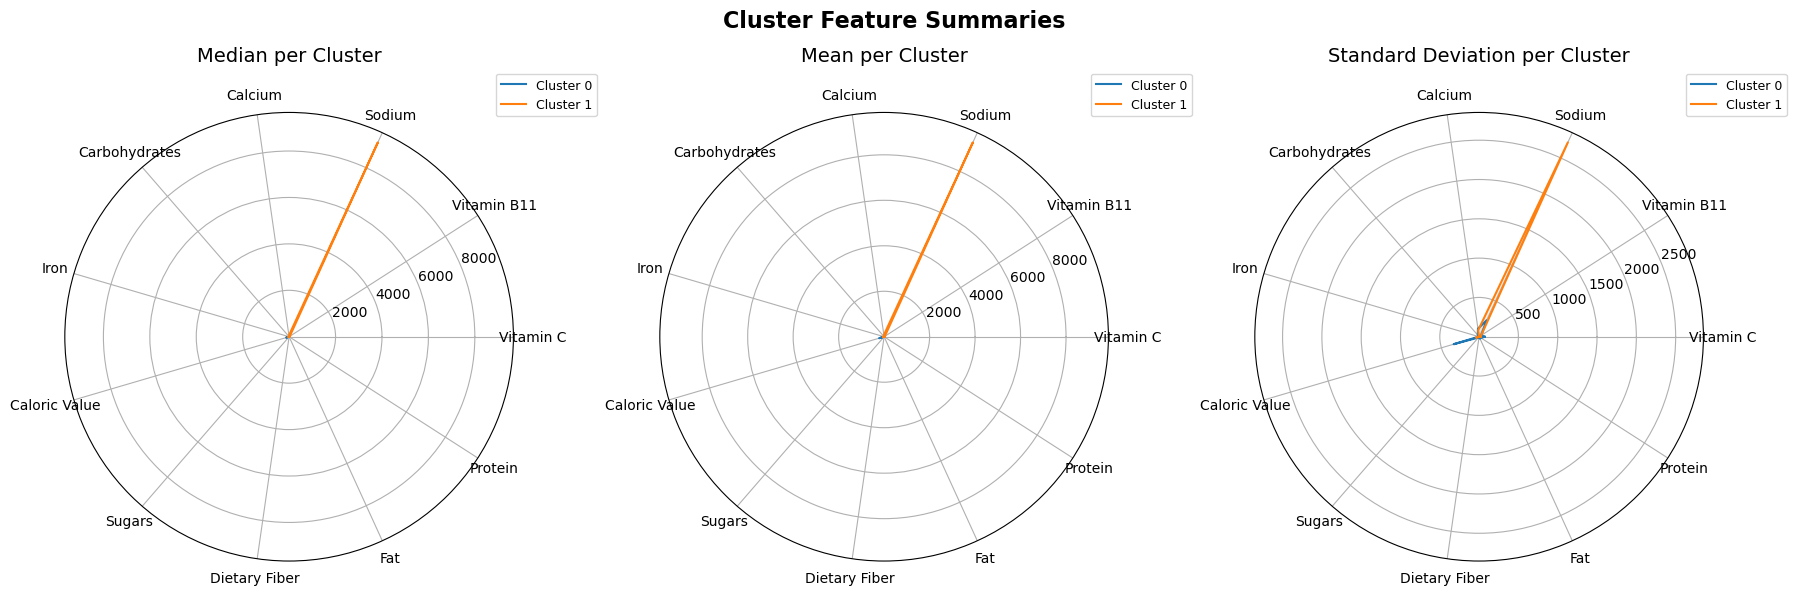


Sample foods in each cluster:

Cluster 0:


,food_normalized,cluster,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
1966,duck liver raw,0,2.000,0.300,0.089,4.800,1.600,13.400,60.000,0.000,0.000,2.000,8.200
1671,bay leaf,0,0.300,0.015,0.084,5.000,0.400,0.300,2.000,0.000,0.200,0.042,0.086
170,english muffin toasted,0,0.900,0.041,0.200,102.400,27.400,2.400,140.000,1.800,1.500,1.100,5.400
1422,pink salmon raw,0,0.000,0.044,0.200,22.300,0.000,1.200,404.000,0.000,0.000,14.000,65.200
322,tomato sauce with onions,0,31.100,0.003,1.300,41.700,24.400,2.300,103.000,0.000,4.400,0.500,3.800
2163,baking powder,0,0.000,0.000,0.500,270.300,1.300,0.500,2.000,0.000,0.030,0.000,0.000
1146,beef vegetable soup,0,9.000,0.085,0.800,45.000,15.400,1.300,120.000,3.100,3.000,2.900,8.000
3447,chikki,0,0.300,0.075,0.150,21.940,50.000,0.700,290.000,0.920,3.000,11.000,5.000
869,beechnuts dried,0,4.700,0.087,0.068,0.300,10.100,0.700,173.000,0.000,0.000,15.000,1.900
621,green olives pickled,0,0.012,0.068,0.100,0.072,0.100,0.071,4.000,0.051,0.057,0.400,0.073



Cluster 1:


,food_normalized,cluster,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
3385,chat masala,1,0.300,0.075,11873.640,519.500,23.870,13.270,222.580,0.790,18.620,9.910,8.190
2862,green pea soup (matar ka soup),1,41.120,65.460,10958.110,46.630,3.630,2.180,39.810,0.870,2.490,12.900,11.060
3308,curried cauliflower soup,1,51.860,53.080,7311.440,37.250,3.120,2.120,37.320,1.790,2.340,9.770,6.720
2864,mixed vegetable soup,1,20.060,31.610,9202.270,50.690,2.950,1.740,35.710,1.640,1.640,11.660,8.220
2473,egg drop soup,1,8.510,28.190,12418.840,100.140,1.100,3.930,26.640,0.600,0.810,13.520,12.930
2475,french onion soup,1,5.350,24.850,11202.890,106.220,4.280,3.520,55.610,1.500,1.010,14.390,11.410
2866,mulligatawny soup,1,8.370,27.880,11602.500,43.890,8.240,2.650,54.420,1.260,2.600,13.280,11.260
2868,cream of broccoli soup,1,68.910,94.430,8792.430,66.550,3.720,1.820,56.140,1.590,1.890,12.750,8.970
2859,meat consomme (with mutton),1,2.440,15.490,12665.520,115.880,0.510,4.220,29.760,0.240,0.710,13.680,14.860
2463,clear tomato soup (tamatar ka soup),1,53.160,43.910,5135.740,29.050,3.450,1.140,80.070,1.440,1.960,12.220,4.790


In [95]:
# Using original dataset
best_k_ori = find_best_k(df_ori)
kmeans_ori = KMeans(n_clusters=best_k_ori, random_state=42)
labels_ori = kmeans_ori.fit_predict(df_ori)
clustering_evaluation_pipeline(df_ori, df_text, labels_ori)

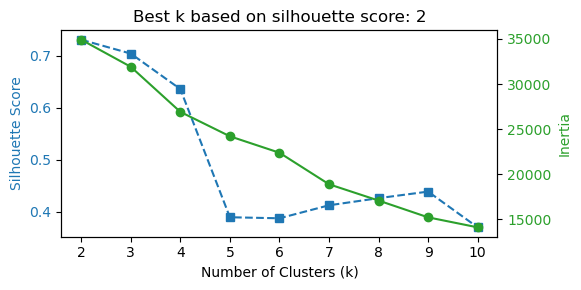

Cluster Evaluation Metrics:
 - Silhouette Score:       0.731
 - Calinski-Harabasz Score: 303.950
 - Davies-Bouldin Score:    0.751



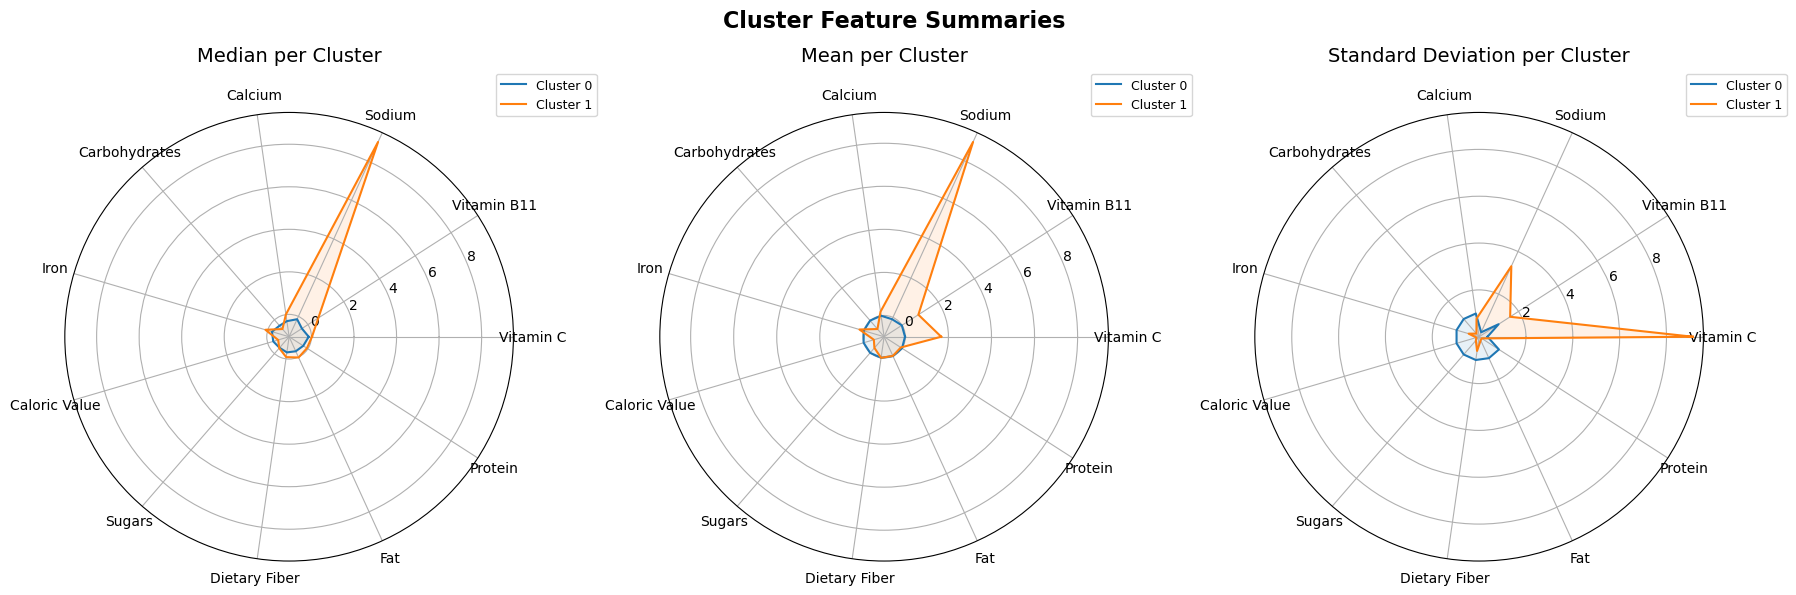


Sample foods in each cluster:

Cluster 0:


,food_normalized,cluster,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
1965,turkey giblets cooked,0,-0.128,-0.332,-0.145,-0.522,-0.714,-0.212,-0.189,-0.433,-0.454,-0.214,0.524
3216,sunflower cookies,0,-0.135,1.188,0.041,0.160,0.813,0.133,0.872,1.415,0.377,0.908,-0.049
170,english muffin toasted,0,-0.122,-0.337,-0.145,0.469,0.331,0.176,-0.261,-0.296,-0.139,-0.408,-0.199
680,chili peppers canned,0,0.540,-0.337,-0.145,-0.038,-0.470,0.039,-0.591,-0.433,0.051,-0.434,-0.360
2858,white stock,0,-0.098,-0.026,-0.144,-0.507,-0.699,-0.365,-0.656,-0.415,-0.419,-0.428,-0.395
1764,french beans cooked,0,-0.132,-0.332,-0.145,-0.522,0.906,-0.326,0.001,-0.433,3.042,-0.401,0.062
3236,coconut pickle (nariyal ka aachar),0,-0.111,-0.174,0.036,-0.089,-0.274,0.226,0.862,0.250,0.883,1.486,-0.286
1766,winged beans raw,0,-0.135,-0.336,-0.145,7.228,2.180,5.217,1.536,-0.433,9.465,0.662,1.585
2842,vermicelli upma (semiya/seviyan upma),0,-0.069,0.035,-0.041,-0.326,-0.070,-0.159,-0.233,-0.327,0.222,-0.171,-0.283
2113,sangiovese red wine,0,-0.135,-0.338,-0.145,-0.522,-0.565,-0.371,-0.302,-0.433,-0.454,-0.449,-0.393



Cluster 1:


,food_normalized,cluster,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
3402,lemon green chilli pickle (nimboo aur hari mirch ka achaar),1,-0.131,-0.336,7.624,-0.328,-0.632,-0.246,-0.635,-0.357,-0.229,-0.440,-0.366
2477,talaumein soup,1,0.044,1.097,11.250,-0.112,-0.555,0.137,-0.571,-0.375,-0.046,0.029,-0.026
2870,almond soup (badam ka soup),1,-0.026,0.804,8.464,0.590,-0.574,0.274,-0.443,-0.286,-0.263,0.067,-0.025
3309,millet soup,1,-0.075,0.442,11.076,0.109,-0.400,0.254,-0.510,-0.323,0.139,0.021,0.016
2860,consomme au julienne,1,0.032,1.295,10.346,0.309,-0.657,0.391,-0.594,-0.370,-0.164,-0.050,0.061
3324,classic seasoned black beans,1,-0.014,-0.202,8.065,-0.134,-0.422,0.062,-0.591,-0.400,0.285,-0.139,-0.103
2865,cheese soup,1,-0.060,0.261,13.930,0.287,-0.643,0.176,-0.555,-0.370,-0.075,0.189,0.058
2475,french onion soup,1,-0.059,0.396,11.368,0.506,-0.551,0.432,-0.512,-0.319,-0.242,0.089,0.022
2470,cream of mushroom soup,1,-0.053,0.569,5.277,0.161,-0.571,0.042,-0.328,-0.287,-0.172,0.131,-0.153
2861,consomme au vermicelli,1,-0.100,0.256,12.726,0.420,-0.664,0.537,-0.588,-0.413,-0.284,0.036,0.162


In [96]:
# Using scaled dataset
best_k_scaled = find_best_k(df_scaled)
kmeans_scaled = KMeans(n_clusters=best_k_scaled, random_state=42)
labels_scaled = kmeans_scaled.fit_predict(df_scaled)
clustering_evaluation_pipeline(df_scaled, df_text, labels_scaled)

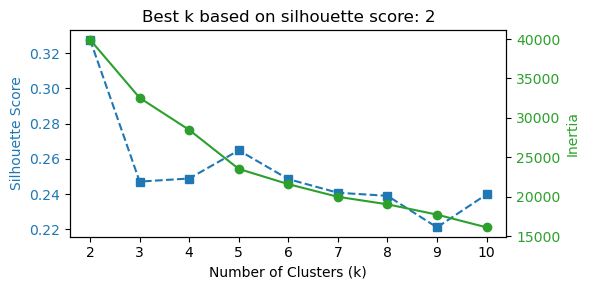

Cluster Evaluation Metrics:
 - Silhouette Score:       0.328
 - Calinski-Harabasz Score: 2241.843
 - Davies-Bouldin Score:    1.143



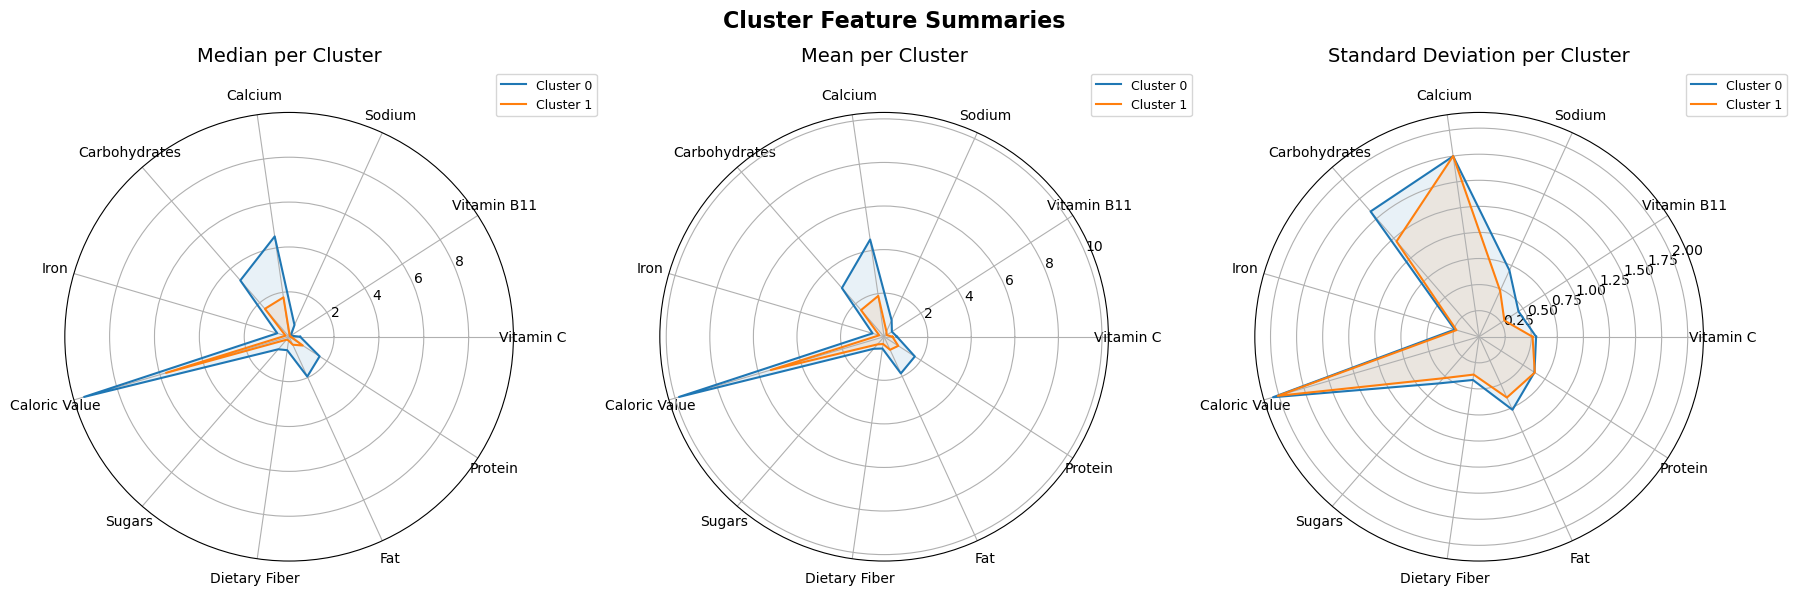


Sample foods in each cluster:

Cluster 0:


,food_normalized,cluster,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
3290,spicy corn chaat,0,1.265,1.046,1.647,3.307,2.729,0.468,11.452,0.561,0.790,2.803,1.437
1049,english muffin with cheese sausage,0,-0.000,0.044,0.459,6.941,3.713,0.813,10.628,0.848,0.353,2.417,2.056
2677,fruit ice cream (phalon ka ice cream),0,0.994,0.979,1.565,5.580,3.100,0.268,8.558,1.429,0.258,1.978,1.407
2036,pork ears cooked,0,-0.000,-0.000,0.173,3.487,0.183,0.654,8.739,-0.000,-0.000,2.064,2.164
2628,tandoori fish,0,1.312,1.009,1.674,4.290,1.262,0.320,7.156,0.748,0.391,1.491,1.928
2612,mutton chops,0,0.974,0.984,1.597,4.250,0.934,0.398,12.484,0.320,0.149,3.007,1.362
2116,carignane red wine,0,-0.000,-0.000,-0.000,0.000,2.780,-0.000,10.668,-0.000,-0.000,-0.000,0.324
3140,savoury cheese horns,0,0.828,0.928,1.706,5.976,3.427,0.394,10.017,0.946,0.455,2.376,1.553
167,oat bran bagel,0,0.092,0.050,0.307,2.461,4.073,0.706,8.625,0.612,0.833,0.558,1.703
2667,carrot halwa (gajar ka halwa),0,1.117,1.024,1.569,5.781,3.263,0.442,8.576,1.468,0.850,1.940,1.216



Cluster 1:


,food_normalized,cluster,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
682,grape leaves canned,1,0.929,0.051,0.501,5.387,1.526,0.455,4.075,-0.000,0.866,0.451,0.724
2311,popcorn oil popped,1,0.080,0.049,0.018,0.341,1.895,0.168,6.265,0.026,0.517,1.512,0.552
579,gourd raw,1,0.022,0.034,0.029,0.046,1.714,0.016,3.990,0.811,0.549,0.179,0.685
2118,semillon white wine,1,-0.000,-0.000,-0.000,0.000,1.818,-0.000,7.698,-0.000,1.219,-0.000,0.094
1808,mutton cooked,1,-0.000,-0.000,0.066,1.416,0.027,0.584,6.331,-0.000,-0.000,1.249,1.840
854,pesca tea santal,1,-0.000,-0.000,-0.000,0.000,0.000,-0.000,7.597,-0.000,-0.000,-0.000,-0.000
343,caesar dressing,1,0.054,0.089,0.173,2.295,0.411,0.168,6.747,0.308,0.035,1.859,0.255
2121,cabernet sauvignon red wine,1,-0.000,-0.000,-0.000,0.000,1.931,-0.000,8.476,-0.000,-0.000,-0.000,0.094
2134,vanilla extract,1,-0.000,-0.000,0.058,0.413,0.411,0.019,3.273,0.364,-0.000,0.066,-0.000
1555,apple,1,0.029,0.086,0.059,0.043,3.614,0.079,7.133,1.490,0.988,0.256,0.388


In [97]:
# Using transformed dataset
best_k_trans = find_best_k(df_trans)
kmeans_trans = KMeans(n_clusters=best_k_trans, random_state=42)
labels_trans = kmeans_trans.fit_predict(df_trans)
clustering_evaluation_pipeline(df_trans, df_text, labels_trans)

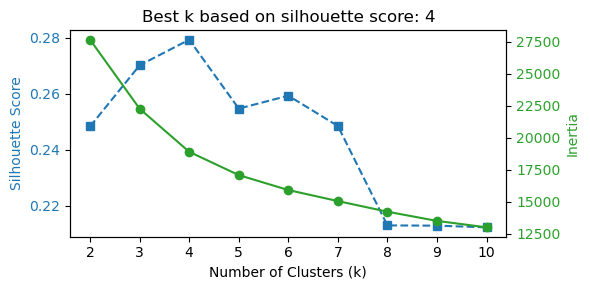

Cluster Evaluation Metrics:
 - Silhouette Score:       0.279
 - Calinski-Harabasz Score: 1162.150
 - Davies-Bouldin Score:    1.410



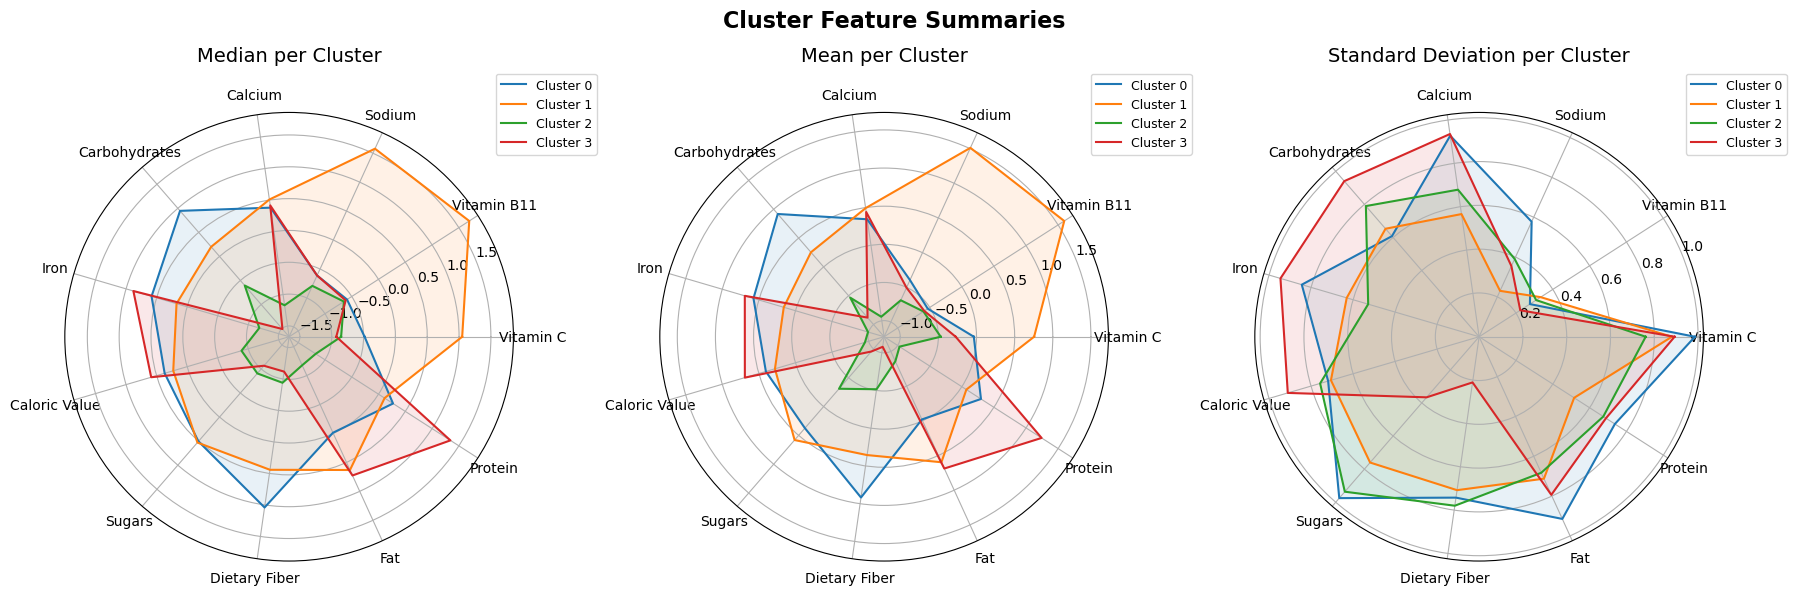


Sample foods in each cluster:

Cluster 0:


,food_normalized,cluster,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
3403,brinjal pickle (baingan ka achaar),0,-0.484,-0.571,1.748,0.406,-0.411,1.038,0.023,-0.029,1.318,0.820,-0.335
1134,bean ham soup,0,0.690,-0.522,-0.333,0.998,0.986,1.159,0.325,1.146,1.697,-0.242,0.759
921,cashew nuts roasted,0,-0.805,-0.561,-0.742,-0.207,0.051,0.880,0.212,0.181,0.220,0.880,0.256
2265,m ms milk chocolate mars,0,-0.611,-0.702,-0.841,0.511,0.900,-0.281,0.364,1.606,0.358,0.579,-0.483
2354,granola bar,0,-0.611,-0.714,-0.751,-0.211,0.324,-0.128,-0.248,1.015,0.292,0.088,-0.379
3364,orange squash (santre ka squash),0,-0.484,-0.571,1.208,-0.309,1.311,-0.570,0.303,1.760,-0.386,-1.410,-1.423
1273,sandwich with cold cuts,0,-0.029,0.652,0.393,-1.557,1.673,-0.281,1.775,1.348,1.328,1.474,1.630
686,tomato paste canned,0,1.681,-0.697,0.368,1.006,1.289,1.862,0.398,1.654,1.732,-0.660,0.823
3448,churros,0,-0.484,-0.571,-0.612,0.090,1.123,0.008,0.767,-0.118,0.747,0.950,0.079
2263,chocolate syrup,0,-0.912,-0.528,-0.781,-0.632,0.778,0.129,-0.173,1.509,0.220,-1.101,-0.962



Cluster 1:


,food_normalized,cluster,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
3128,flan pastry,1,-0.928,1.457,1.635,0.087,1.262,0.468,1.096,1.034,0.568,1.219,0.456
3187,semolina milk drink (thari kanji),1,1.135,1.581,1.141,-0.438,-0.117,-0.531,-0.825,0.773,-0.018,-0.594,-0.854
2965,okra/lady's fingers fry (bhindi sabzi/sabji/subji),1,1.576,1.769,1.565,0.787,-0.376,0.217,-0.160,0.146,1.157,0.605,-0.472
2775,hot spinach souffle,1,1.657,1.793,1.578,0.902,-0.416,0.813,-0.208,0.237,0.212,0.445,0.302
2769,cheese balls,1,-0.910,1.116,1.593,0.274,-0.337,-0.611,1.548,-0.326,-0.736,1.795,-0.344
3278,moong bean dosa (pesarattu),1,0.333,1.615,1.511,0.392,0.950,1.388,0.660,0.598,1.469,0.753,0.882
2722,onion pakora/pakoda (pyaaz ke pakode),1,1.045,1.779,1.516,-0.457,-0.268,-0.531,1.537,-0.144,0.298,1.790,-0.447
3080,curd mint dip,1,0.798,1.484,1.646,1.429,0.059,0.151,-0.446,1.148,0.029,-0.257,0.215
2662,cauliflower kheer (phoolgobhi ki kheer),1,1.537,1.725,1.347,1.058,0.035,-0.653,-0.391,1.186,-0.198,0.049,-0.119
2434,pea potato sandwich (toasted) (matar aloo ka sandwich),1,1.405,1.671,1.657,0.750,0.771,0.434,0.166,0.105,1.014,0.256,0.181



Cluster 2:


,food_normalized,cluster,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
1557,prickly pear cooked,2,-0.272,-0.740,-0.867,-1.568,-0.889,-1.477,-1.827,-1.066,-1.116,-1.407,-1.563
383,koyadofu,2,-0.876,-0.690,-0.755,-1.568,-0.863,-0.884,-0.400,-1.066,0.358,0.228,0.657
2056,quail egg,2,-0.928,-0.542,-0.807,-0.608,-1.461,-0.653,-1.499,-0.987,-1.116,-0.750,-0.738
186,peanut butter sandwich cookies,2,-0.769,-0.651,-0.733,-0.492,0.065,-0.454,-0.538,0.917,-0.533,-0.128,-0.738
1681,peppermint,2,-0.821,-0.681,-0.857,-1.568,-1.394,-1.220,-2.429,-1.066,-0.891,-1.448,-1.627
284,peppercorn dressing,2,-0.774,-0.711,-0.731,-0.903,-1.250,-1.292,-0.447,-0.645,-1.116,0.526,-1.444
184,shortbread cookies,2,-0.928,-0.625,-0.734,-0.916,-0.292,-0.884,-0.890,0.041,-0.891,-0.407,-1.173
827,apple juice martinellis,2,-0.928,-0.740,-0.867,-1.568,-1.509,-1.477,-0.083,-1.066,-1.116,-1.453,-1.675
1004,american cheese spread,2,-0.928,-0.590,-0.508,0.974,-0.942,-1.217,-0.798,0.041,-1.116,-0.048,-0.230
1199,beef broth powder,2,-0.928,-0.575,-0.073,-1.004,-1.209,-1.374,-1.768,-0.351,-1.116,-1.176,-1.097



Cluster 3:


,food_normalized,cluster,Vitamin C,Vitamin B11,Sodium,Calcium,Carbohydrates,Iron,Caloric Value,Sugars,Dietary Fiber,Fat,Protein
2216,danish pastry with cheese,3,0.668,-0.658,-0.508,0.808,0.869,0.880,0.862,-1.066,-1.116,1.208,0.350
2159,popover dry mix,3,-0.611,-0.335,0.189,0.644,2.015,1.639,1.464,-1.066,-1.116,0.450,1.122
1424,mackerel raw,3,-0.372,-0.723,-0.731,-0.186,-1.509,0.880,0.458,-1.066,-1.116,0.934,1.225
2160,egg substitute powder,3,-0.611,-0.700,-0.612,0.992,-0.186,0.238,-0.057,1.032,-1.116,0.006,1.044
2037,pork tongue cooked,3,0.890,-0.695,-0.508,0.508,-1.509,2.009,1.455,-1.066,-1.116,1.523,1.795
1811,veal sirloin cooked,3,-0.928,-0.665,-0.612,0.366,-1.509,1.159,1.250,-1.066,-1.116,1.260,1.868
1439,ling raw,3,-0.928,-0.620,-0.508,0.765,-1.509,0.583,0.182,-1.066,-1.116,-0.660,1.566
2048,chicken leg fried,3,-0.928,-0.542,-0.416,0.241,0.339,1.054,1.062,-1.066,-0.257,1.229,1.529
1919,caribou cooked,3,-0.928,-0.614,-0.861,-0.547,-1.509,1.763,0.377,-1.066,-1.116,0.364,1.586
1405,eel raw,3,0.862,-0.627,-0.731,0.462,-1.509,0.336,0.922,-1.066,-1.116,1.189,1.580


In [98]:
# Using transformed and scaled dataset
best_k_trans_scaled = find_best_k(df_trans_scaled)
kmeans_trans_scaled = KMeans(n_clusters=best_k_trans_scaled, random_state=42)
labels_trans_scaled = kmeans_trans_scaled.fit_predict(df_trans_scaled)
clustering_evaluation_pipeline(df_trans_scaled, df_text, labels_trans_scaled)

#### 2.2 Distance-based Method: Hierarchical Clustering